In [89]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

drive_dir = '/Users/christiandewey/Library/CloudStorage/GoogleDrive-christian.w.dewey@gmail.com/My Drive/manuscripts/2023_Dewey-Boiteau-etal_mz-windowing/' 
data_dir = drive_dir +'assignments/wastewater-final-eff/'
svdir = drive_dir + 'figures/'


In [6]:
## PLOTTING FUNCS
def vanKrevelen(df,ax,hcol,col,leg=False):
    if leg is False:
        ax = sns.scatterplot(data=df,x='O/C',y='H/C',size = (df['Peak Height']/max(df['Peak Height'])),hue = hcol,ax = ax,sizes=(20, 100),color=col,alpha = 0.25, legend=False) #(df['Peak Height']/max(df['Peak Height']))  (df['Peak Height']/max(df['Peak Height']))
        ax.set_ylim(0.,3.)
        ax.set_xlim(0.,1.5)
    else:
        ax = sns.scatterplot(data=df,x='O/C',y='H/C',size = (df['Peak Height']/max(df['Peak Height'])),hue = hcol,ax = ax,sizes=(20, 100),color=col,alpha = 0.25) #(df['Peak Height']/max(df['Peak Height']))  (df['Peak Height']/max(df['Peak Height']))
        ax.set_ylim(0.,3.)
        ax.set_xlim(0.,1.5)

def panelLabel(ax,lbl):
    ax.text(-.15, 1.1,lbl,
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax.transAxes, fontweight='bold', fontsize = 10)

In [8]:
data_df = pd.read_csv(data_dir+'p230215_wastewater-final-eff_neg_21TNHMFL-Jan_001.csv'  ) 

data_df = lcmsfns.add_mzwindow_col(data_df)

data_df = lcmsfns.addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())
print(data_df['Window Size (m/z)'].unique())



## add mol classes 
heter = ['N','Na','S','P', 'Fe', 'Cu']
molclasses = lcmsfns.get_mol_class(heter)

data_df = lcmsfns.assign_mol_class(data_df,molclasses)



## create blankfiles 

# create 200 m/z blank files from 100 m/z blank files and add column with blank file identity 

flist = data_df.file.unique()
blank_files = [f for f in flist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    if 'fullmz' not in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_df = pd.concat(blank_data)

rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
rep1_temp = rep1_temp[rep1_temp['m/z'] <= 600]
rep1_temp['file'] = 'mz200_400_600_blnk'
rep1_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])

rep2_temp = blanks_df[blanks_df['file'].str.contains('rep2')]
rep2_temp = rep2_temp[rep2_temp['m/z'] <= 600]
rep2_temp['file'] = 'mz200_400_600_blnk_rep2'
rep2_temp['m/z window'] = '400-600 m/z'


blanks_df = pd.concat([blanks_df,rep2_temp])

print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())

mz200_blanks = blanks_df[blanks_df['m/z window'] == '400-600 m/z']
mz200_blanks['Window Size (m/z)'] = '200'

n200bs = len(mz200_blanks)
max_index = max(data_df.index)
compatible_index = range(max_index, max_index+n200bs,1)
mz200_blanks.index = compatible_index

data_df = pd.concat([data_df, mz200_blanks])

blank_data = []

for f in blank_files:

    if 'fullmz' in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_fullmz_df = pd.concat(blank_data)
temp = blanks_df
blanks_df = pd.concat([blanks_df,blanks_fullmz_df])

df_bs = []
for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window
    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]

        temp2['blank file'] = btemp2['file'].iloc[0]
        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2

        df_bs.append(temp2)

df_bs = pd.concat(df_bs)

data_df =df_bs

20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
[2 1]
['400-500 m/z' '200-1200 m/z' '500-600 m/z' '400-600 m/z']
[2 1]
['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600

In [ ]:
#### LOAD PROCESSED DATA SET FOR FIGURES 

data_df = pd.read_csv(data_dir+'p230215_wastewater-final-eff_neg_21TNHMFL-Jan_001.csv'  ) 


data_df['Window Size (m/z)'] = data_df['Window Size (m/z)'].map(str)

# create subsets of assignments based m/z window
list100mz = []
list200mz = []
listfullzmz = [] 
for mzwindow in data_df['Window Size (m/z)'].unique():

    r_df = data_df[data_df['Window Size (m/z)'] == mzwindow]

    if (mzwindow =='100'):
        list100mz.append(r_df) 

    elif (mzwindow =='200'):
        list200mz.append(r_df) 

    elif (mzwindow =='1000'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz,ignore_index=True)
mz200 = pd.concat(list200mz,ignore_index=True)
mzfull = pd.concat(listfullzmz,ignore_index=True)


# create subsets of assigned features and unique features 

assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

unique_100mz = lcmsfns.getUniqueFeatures(assigned_100mz)
unique_200mz = lcmsfns.getUniqueFeatures(assigned_200mz)
unique_fullmz = lcmsfns.getUniqueFeatures(assigned_fullmz)


print('100 m/z window: \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], (np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100), np.shape(unique_100mz)[0]))
print('\n200 m/z window: \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mz200)[0],  np.shape(assigned_200mz)[0], (np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100), np.shape(unique_200mz)[0]))
print('\n200-1200 m/z window (full scan): \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  (np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100),np.shape(unique_fullmz)[0]))

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=600)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=600)]

unique_fullmz_456 = lcmsfns.getUniqueFeatures(assigned_fullmz_456)

print('400-600 m/z, 200-1200 m/z window: \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100, len(unique_fullmz_456)))

# get combo unique 
import matplotlib.gridspec as gridspec

combo = pd.concat([assigned_100mz, assigned_200mz, assigned_fullmz_456], ignore_index=True)
combo_unique = lcmsfns.getUniqueFeatures(combo)
combo_bs = pd.concat([lcmsfns.blankSubtract(unique_fullmz_456, blnkthresh = 0.6), 
    lcmsfns.blankSubtract(unique_200mz, blnkthresh = 0.6), 
    lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)], ignore_index=True)
# combo without blank subtraction or removal of duplicate peaks
mzfull_456 = mzfull[(mzfull['Calibrated m/z']>=400) & (mzfull['Calibrated m/z']<=600)]
combo2 = pd.concat([mz100, mz200, mzfull_456], ignore_index=True)
dd = lcmsfns.blankSubtract(combo_unique)
print('\ncombo, with unassigned: %s\ncombo, with duplicates: %s\ncombo, blank subtract: %s\ncombo, no duplicates: %s\ncombo, BS + no dups: %s' %(len(combo2),len(combo),len(combo_bs),len(combo_unique),len(dd)))

# display sets of mfs 

dd = lcmsfns.blankSubtract(combo_unique)
fullscan =  dd[dd['Window Size (m/z)'] == '1000']
midscan = dd[dd['Window Size (m/z)'] == '200']
narrowscan = dd[dd['Window Size (m/z)'] == '100']


narrow_only = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
mid_only = dd[(dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
full_only = dd[(dd['Molecular Formula'].isin(fullscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(midscan['Molecular Formula']))]

narrow_full = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
narrow_mid = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
mid_full = dd[~(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]

features_in_all = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
#features_not_in_full = dd[(dd['Molecular Formula'].isin(narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
features_not_in_full = dd[(~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]

narrow_only['FeatureIn'] = '100'
mid_only['FeatureIn'] = '200'
full_only['FeatureIn'] ='1000'

narrow_full['FeatureIn'] = '100,1000'
narrow_mid['FeatureIn'] = '100,200'
mid_full['FeatureIn'] = '200,1000'

features_in_all['FeatureIn'] = '100,200,1000'

print('\nMFs in narrow window only: %s' %len(narrow_only))
print('MFs in mid window only: %s' %len(mid_only))
print('MFs in full window only: %s' %len(full_only))
print('MFs in narrow and full window only: %s' %len(narrow_full))
print('MFs in narrow and mid window only: %s' %len(narrow_mid))
print('MFs in mid and full window only: %s' %len(mid_full))
print('MFs in all: %s' %len(features_in_all))
print('MFs not in full: %s' %len(features_not_in_full))



In [99]:
#### LOAD PROCESSED wastewater DATA SET FOR FIGURES 

data_df = pd.read_csv(data_dir+'p230215_wastewater-final-eff_neg_21TNHMFL-Jan_001.csv'  ) 


data_df['Window Size (m/z)'] = data_df['Window Size (m/z)'].map(str)

# create subsets of assignments based m/z window
list200mz = []
listfullzmz = [] 
for mzwindow in data_df['Window Size (m/z)'].unique():

    r_df = data_df[data_df['Window Size (m/z)'] == mzwindow]

    if (mzwindow =='100'):
        list100mz.append(r_df) 

    elif (mzwindow =='200'):
        list200mz.append(r_df) 

    elif (mzwindow =='1000'):
        listfullzmz.append(r_df) 

mz200 = pd.concat(list200mz,ignore_index=True)
mzfull = pd.concat(listfullzmz,ignore_index=True)


# create subsets of assigned features and unique features 

assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

unique_200mz = lcmsfns.getUniqueFeatures(assigned_200mz)
unique_fullmz = lcmsfns.getUniqueFeatures(assigned_fullmz)


print('\n200 m/z window: \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mz200)[0],  np.shape(assigned_200mz)[0], (np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100), np.shape(unique_200mz)[0]))
print('\n200-1200 m/z window (full scan): \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  (np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100),np.shape(unique_fullmz)[0]))

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=600)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=600)]

unique_fullmz_456 = lcmsfns.getUniqueFeatures(assigned_fullmz_456)

print('400-600 m/z, 200-1200 m/z window: \n%s features total; %s assigned (%.1f%%); %s unique' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100, len(unique_fullmz_456)))

# get combo unique 
import matplotlib.gridspec as gridspec

combo = pd.concat([assigned_200mz, assigned_fullmz_456], ignore_index=True)
combo_unique = lcmsfns.getUniqueFeatures(combo)
combo_bs = pd.concat([lcmsfns.blankSubtract(unique_fullmz_456, blnkthresh = 0.6), 
    lcmsfns.blankSubtract(unique_200mz, blnkthresh = 0.6)], ignore_index=True)
# combo without blank subtraction or removal of duplicate peaks
mzfull_456 = mzfull[(mzfull['Calibrated m/z']>=400) & (mzfull['Calibrated m/z']<=600)]
combo2 = pd.concat([mz200, mzfull_456], ignore_index=True)
dd = lcmsfns.blankSubtract(combo_unique)
print('\n%s features total' %len(combo2))
print('%s assigned features' %len(combo))
print('%s unique features' %len(combo_unique))
print('%s unique features after blank subtraction' %len(combo_bs))
#print('combo, BS + no dups: %s' %(len(dd)))

# display sets of mfs 

dd = lcmsfns.blankSubtract(combo_unique)
fullscan =  dd[dd['Window Size (m/z)'] == '1000']
midscan = dd[dd['Window Size (m/z)'] == '200']


mid_only = dd[(dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
full_only = dd[(dd['Molecular Formula'].isin(fullscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(midscan['Molecular Formula']))]

mid_full = dd[ (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]

features_in_all = dd[ (dd['Molecular Formula'].isin(midscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]
features_not_in_full = dd[(~dd['Molecular Formula'].isin(fullscan['Molecular Formula']))]

mid_only['FeatureIn'] = '200'
full_only['FeatureIn'] ='1000'
mid_full['FeatureIn'] = '200,1000'

features_in_all['FeatureIn'] = '100,200,1000'

print('\n%s MFs in 200 m/z window only' %len(mid_only))
print('%s MFs in full window only' %len(full_only))
#print('%s MFs in 200 m/z and full window only' %len(mid_full))
print('%s MFs in both windows' %len(features_in_all))
#print('%s MFs not in full' %len(features_not_in_full))




200 m/z window: 
32115 features total; 29273 assigned (91.2%); 9096 unique

200-1200 m/z window (full scan): 
28924 features total; 25653 assigned (88.7%); 9119 unique
400-600 m/z, 200-1200 m/z window: 
10104 features total; 9342 assigned (92.5%); 3371 unique

42219 features total
38615 assigned features
10649 unique features
10543 unique features after blank subtraction

5666 MFs in 200 m/z window only
1859 MFs in full window only
1281 MFs in both windows


['CHO' 'CHON' 'CHONNa' 'CHONS' 'CHONP' 'CHONa' 'CHONaCu' 'CHOS' 'CHOSP'
 'CHOSFe' 'CHOP' 'CHOPFe' 'CHOFeCu' 'CHONNaS' 'CHONNaP' 'CHONNaFe'
 'CHONSP' 'CHONSFe' 'CHONSCu' 'CHONPFe' 'CHONPCu' 'CHONNaSP' 'CHONNaSFe'
 'CHONNaPFe' 'CHONNaFeCu' 'CHONNaSPFe' 'CHONNaSPCu' 'CHONNaSFeCu'
 'CHONNaSPFeCu' 'Unassigned' 'CHONFe' 'CHONaP' 'CHONaFe' 'CHONNaCu'
 'CHONCu' 'CHOPCu' 'CHONFeCu' 'CHONNaSCu' 'CHONNaPCu' 'CHONaS' 'CHOCu'
 'CHOFe' 'CHOSCu']


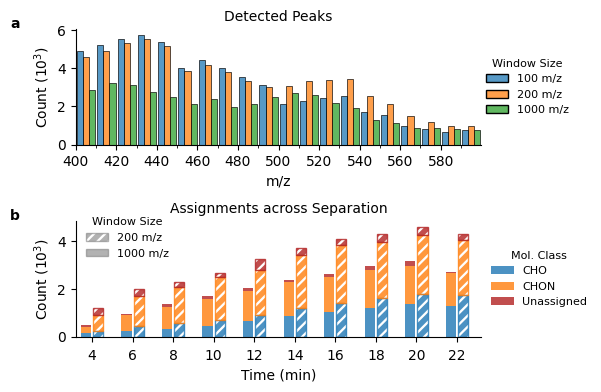

In [10]:
## Figure 1: (a) Total detected features; (b) Assignments along separation 

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

fig, (ax2,ax4) = plt.subplots(nrows=2, ncols=1, figsize = (6,4))
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])

plt.rcParams['legend.title_fontsize'] = 8


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="m/z", hue="Window Size (m/z)", multiple="dodge", ax=ax2,binwidth=10, shrink = 0.9)
ax2.set_ylabel('Count ($10^3$)')
ax2.set_xlim(400,600)
major_tick_locs = range(400,600,20)
minor_tick_locs = range(400,600,10)
ax2.set_xticks(major_tick_locs, minor=False)
ax2.set_xticks(minor_tick_locs, minor=True)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','200 m/z','1000 m/z']
ax2.set_title('Detected Peaks', fontsize = 10)

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
fig = plt.gcf()

ax2.legend(handles, labels, bbox_to_anchor=(1.0, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})
lbla = ax2.text(-0.15, 1.05,'a',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax2.transAxes, fontweight='bold', fontsize = 10)

ax4 = plt.subplot(gs2[0])


all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=700)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=700)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['Window Size (m/z)'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHON', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['Window Size (m/z)']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='200 m/z']
ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4, color=['C0','C1','firebrick'], alpha=0.8)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        ax4.patches[i+(2*n)].set_alpha(0.8)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('firebrick')
        ax4.patches[i+(2*n)].set_fill(None)

major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
ax4.set_xticks(major_tick_locs)

major_tick_labels = df['Time'].unique()
ax4.xaxis.set_ticklabels(major_tick_labels)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Count ($10^3$)')

ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, title='Mol. Class')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray',  alpha=a_val, facecolor = 'white', hatch = '///',label='200 m/z')

plt.legend(handles=[patch_100,patch_full], loc='upper left', bbox_to_anchor=(0, 1.12), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.
sns.despine(ax=ax4)
lblb = ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
fig = plt.gcf()

fig.tight_layout(pad = 1)

plt.savefig(svdir + 'peaks_hist,sep.pdf', bbox_extra_artists=(leg,lblb,lbla), bbox_inches='tight')

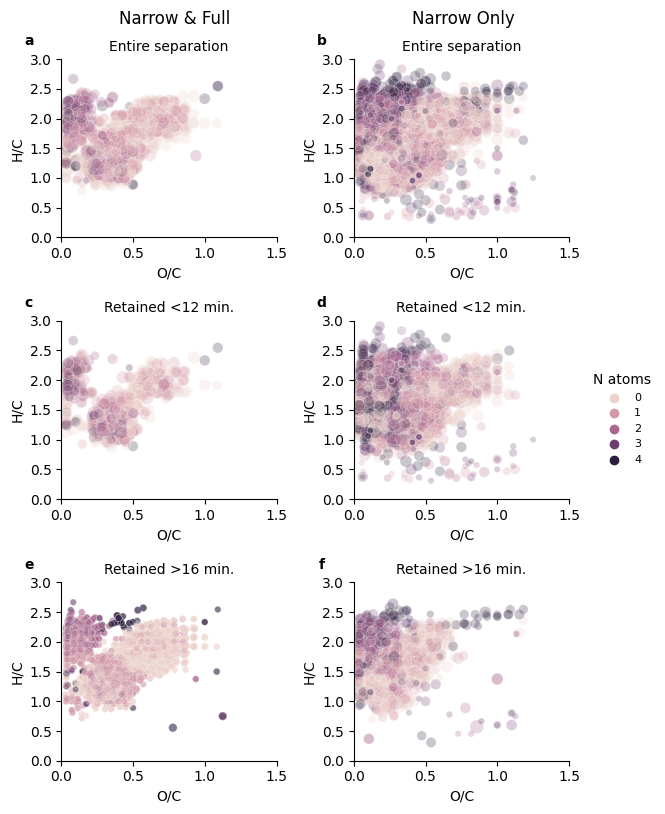

In [13]:
## FIGURES 2&3 van Krevelen plots for (i) features in narrow and full windows and (ii) features not in full window, with N and Fe coloring for different S/N bins

time = 12
time2 = 16
snthresh = 5
snthresh_low = 0
el = 'N'
ttt = 'vanKrevelen_N_0-SN-5.pdf'
fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

df = features_in_all[(features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax,el,'C0')
ax.set_title('Entire separation', size = 10)

df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax2,el,'C0')
ax2.set_title('Retained <%s min.' %time, size = 10)

df = features_in_all[features_in_all['Time']>time2 & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax3,el,'C0')
ax3.set_title('Retained >%s min.' %time2, size = 10)


dfm = features_not_in_full

df = dfm[(dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax4,el,'C1')
ax4.set_title('Entire separation', size = 10)

df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax5,el,'C1')
ax5.set_title('Retained <%s min.' %time, size = 10)

df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax6,el,'C1',leg=True)
ax6.set_title('Retained >%s min.' %time2, size = 10)
h, l = ax6.get_legend_handles_labels()
legend = ax6.legend()
legend.remove()

if el == 'Fe':
    L = fig.legend(h[1:3],l[1:3],title = 'Fe atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    L.get_texts()[0].set_text('0')
    L.get_texts()[1].set_text('1')

elif el == 'N':
    L = fig.legend(h[1:6],l[1:6],title = 'N atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    L.get_texts()[0].set_text('0')
    L.get_texts()[1].set_text('1')
    L.get_texts()[2].set_text('2')
    L.get_texts()[3].set_text('3')
    L.get_texts()[4].set_text('4')


plt.setp(L.get_title(),fontsize=10)

axs = [ax, ax2, ax3, ax4, ax5, ax6]
lbls = ['a','c','e','b','d','f']
for ax, lbl in zip(axs,lbls):
    panelLabel(ax,lbl)

fig.tight_layout()
fig.text(0.3, 1.0,'Narrow & Full',
    horizontalalignment='center',
    verticalalignment='center', fontsize = 12)

fig.text(0.78, 1.0,'Narrow Only',
    horizontalalignment='center',
    verticalalignment='center', fontsize = 12)


sns.despine()

plt.savefig(svdir+ttt, bbox_inches = 'tight')

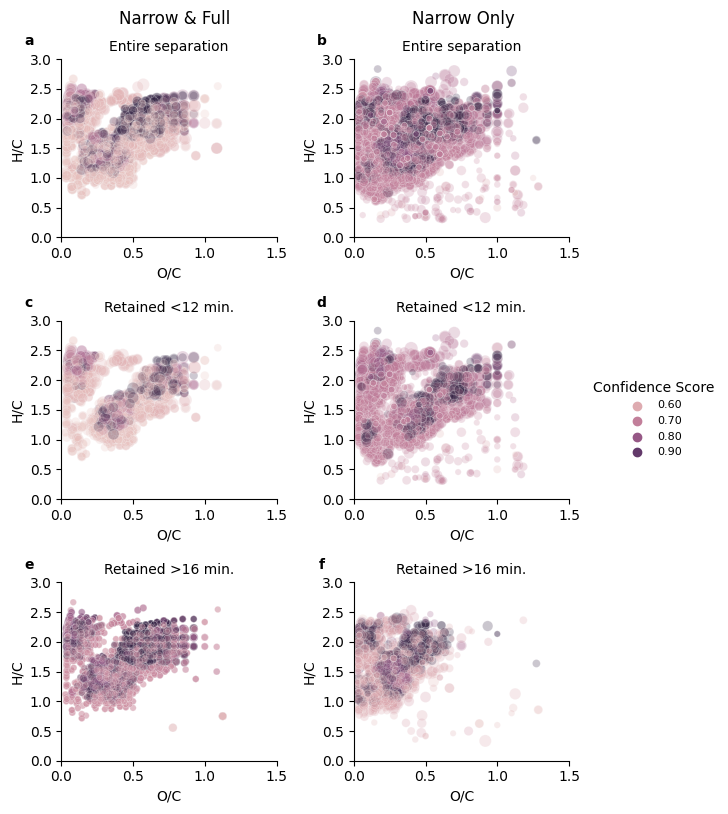

In [12]:
## FIGURES 4 van Krevelen plots for (i) features in narrow and full windows and (ii) features not in full window, with DBE coloring for different S/N bins

time = 12
time2 = 16
snthresh = 20
snthresh_low = 5
el = 'Confidence Score'
ttt = 'vanKrevelen_Cscore_5-SN-20.pdf'
fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

df = features_in_all[(features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax,el,'C0')
ax.set_title('Entire separation', size = 10)

df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax2,el,'C0')
ax2.set_title('Retained <%s min.' %time, size = 10)

df = features_in_all[features_in_all['Time']>time2 & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax3,el,'C0')
ax3.set_title('Retained >%s min.' %time2, size = 10)


dfm = features_not_in_full

df = dfm[(dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax4,el,'C1')
ax4.set_title('Entire separation', size = 10)

df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax5,el,'C1')
ax5.set_title('Retained <%s min.' %time, size = 10)

df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax6,el,'C1',leg=True)
ax6.set_title('Retained >%s min.' %time2, size = 10)
h, l = ax6.get_legend_handles_labels()
legend = ax6.legend()
legend.remove()

'''if el == 'Fe':
    L = fig.legend(h[1:3],l[1:3],title = 'Fe atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    L.get_texts()[0].set_text('0')
    L.get_texts()[1].set_text('1')

elif el == 'N':
    L = fig.legend(h[1:6],l[1:6],title = 'N atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    L.get_texts()[0].set_text('0')
    L.get_texts()[1].set_text('1')
    L.get_texts()[2].set_text('2')
    L.get_texts()[3].set_text('3')
    L.get_texts()[4].set_text('4')'''

L = fig.legend(h[1:-6],l[1:-6],title = 'Confidence Score',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')

for i, dbe in zip(range(len(h)-7),l[1:-6]):
    L.get_texts()[i].set_text('%.2f' % float(dbe))

plt.setp(L.get_title(),fontsize=10)

axs = [ax, ax2, ax3, ax4, ax5, ax6]
lbls = ['a','c','e','b','d','f']
for ax, lbl in zip(axs,lbls):
    panelLabel(ax,lbl)

fig.tight_layout()
fig.text(0.3, 1.0,'Narrow & Full',
    horizontalalignment='center',
    verticalalignment='center', fontsize = 12)

fig.text(0.78, 1.0,'Narrow Only',
    horizontalalignment='center',
    verticalalignment='center', fontsize = 12)


sns.despine()

plt.savefig(svdir+ttt, bbox_inches = 'tight')

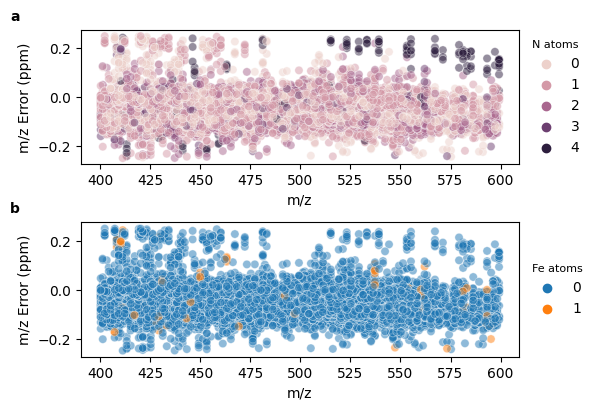

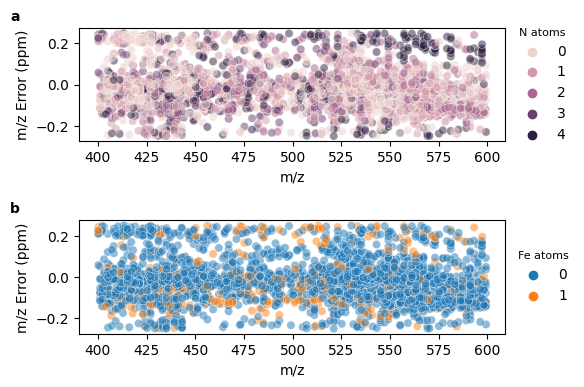

In [14]:
# plot assignment error  
import itertools
ttt = 'Title'

# set palette 
palette = itertools.cycle(sns.color_palette())


fig, (ax1, ax3) = plt.subplots(2, 1, figsize = (6,4))

df = features_in_all
ax1 =sns.scatterplot(data=df[df['mol_class']!='Unassigned'], x="m/z", y="m/z Error (ppm)",alpha = 0.5, hue="N", ax = ax1)
ax1.legend(frameon = False, bbox_to_anchor= (1.0,0.5), loc = 'center left')
L = ax1.legend(frameon = False,title = 'N atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
L.get_texts()[0].set_text('0')
L.get_texts()[1].set_text('1')
L.get_texts()[2].set_text('2')
L.get_texts()[3].set_text('3')
L.get_texts()[4].set_text('4')


df = features_in_all
ax3 =sns.scatterplot(data=df[df['mol_class']!='Unassigned'], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue="Fe",color = ['C0','C1'], ax = ax3)
L = ax3.legend(frameon = False,title = 'Fe atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
L.get_texts()[0].set_text('0')
L.get_texts()[1].set_text('1')

fig.tight_layout()
axs = [ax1, ax3]
lbls = ['a','b']
for ax, lbl in zip(axs,lbls):
    panelLabel(ax,lbl)
plt.savefig(svdir+'both_windows_error-ppm.pdf', bbox_inches = 'tight')


fig, (ax2,ax4) = plt.subplots(2, 1, figsize = (6,4))

df = mid_only
ax2 =sns.scatterplot(data=df[df['mol_class']!='Unassigned'], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue="N", ax = ax2)
ax2.legend(frameon = False, bbox_to_anchor= (1.0,0.5), loc = 'center left')
L = ax2.legend(frameon = False,title = 'N atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
L.get_texts()[0].set_text('0')
L.get_texts()[1].set_text('1')
L.get_texts()[2].set_text('2')
L.get_texts()[3].set_text('3')
L.get_texts()[4].set_text('4')

df = mid_only
ax4 =sns.scatterplot(data=df[df['mol_class']!='Unassigned'], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue="Fe",color = ['C0','C1'], ax = ax4)
L = ax4.legend(frameon = False,title = 'Fe atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
L.get_texts()[0].set_text('0')
L.get_texts()[1].set_text('1')

axs = [ax2, ax4]
lbls = ['a','b']
for ax, lbl in zip(axs,lbls):
    panelLabel(ax,lbl)


fig.tight_layout()
plt.savefig(svdir+'mid_only_error-ppm.pdf', bbox_inches = 'tight')

In [67]:
print(len(features_in_all[features_in_all['Cu']>0]))

print(len(features_not_in_full[features_not_in_full['Cu']>0]))

cu_n = features_not_in_full[(features_not_in_full['Cu']>0) & (features_not_in_full['P']<3)]

print(len(cu_n))

print(max(data_df['S']))
print(max(data_df['P']))
print(max(data_df['N']))
print(max(data_df['Fe']))
print(max(data_df['Cu']))
print(max(data_df['Na']))
print(max(data_df['C']))
print(max(data_df['H']))
print(max(data_df['O']))

54
609
563
3.0
3.0
4.0
1.0
1.0
1.0
40.0
79.0
18.0


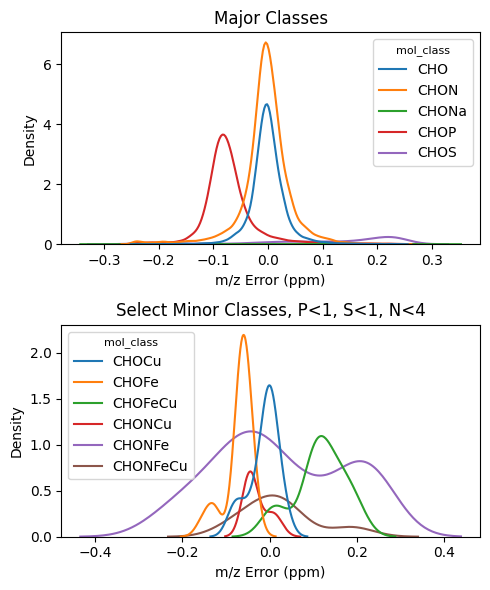

In [87]:
column = 'm/z Error (ppm)'  ## title for main plot
hue_col = 'mol_class'
fig, (ax,ax1) = plt.subplots(2,1, figsize = (5,6))


df = pd.concat([unique_100mz,unique_200mz, unique_fullmz_456])
df = df[(df['mol_class'] =='CHO') | (df['mol_class'] =='CHON') | (df['mol_class'] =='CHOS') | (df['mol_class'] =='CHOP')| (df['mol_class'] =='CHONa')]
df.sort_values(by=['mol_class'],inplace=True)
ax = sns.kdeplot(data=df, x=column, hue=hue_col, ax = ax, legend=True)
ax.set_title('Major Classes')


df = pd.concat([unique_100mz,unique_200mz, unique_fullmz_456])
df = df[ (df['Fe']>0) | (df['Cu']>0)]
df = df[(df['P']<1) & (df['S']<1)  & (df['N']<4)]
df = df[~df['mol_class'].str.contains('Na')]
#df = df[(df['mol_class'] =='CHO') | (df['mol_class'] =='CHON') | (df['mol_class'] =='CHOS') | (df['mol_class'] =='CHOP')| (df['mol_class'] =='CHONa')]
df.sort_values(by=['mol_class'],inplace=True)
ax1 = sns.kdeplot(data=df, x=column, hue=hue_col, ax = ax1, legend = True)
ax1.set_title('Select Minor Classes, P<1, S<1, N<4')

#plt.legend(frameon = False)
#fig.suptitle(ttt, fontsize=14)
#fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.savefig(data_dir+'spring-env/230215_spring_pos_kde_assign.pdf')


In [55]:
print(len(df[df['mol_class']=='CHOCu']))

19


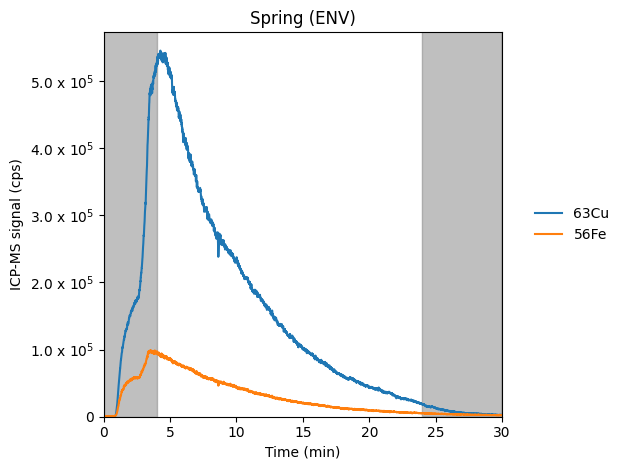

In [2]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_env.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu','56Fe']

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Spring (ENV)')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(0,30)
ax.set_ylim(bottom = 0)

x = np.arange(0.0, 4, 0.01)
ax.fill_between(x, 0,1e6,  color = 'gray',alpha=0.5)
x = np.arange(24, 30, 0.01)
ax.fill_between(x, 0,1e6, color = 'gray', alpha=0.5)
current_yvalues = plt.gca().get_yticks()
ylabs = []
for y in current_yvalues:
    if y == 0:
        d = int(0)
    else:
        d = '{:.1f} x $10^5$'.format(y/1e5)
    ylabs.append(d)
#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
plt.gca().set_yticklabels(ylabs)
fig.tight_layout()
plt.show()

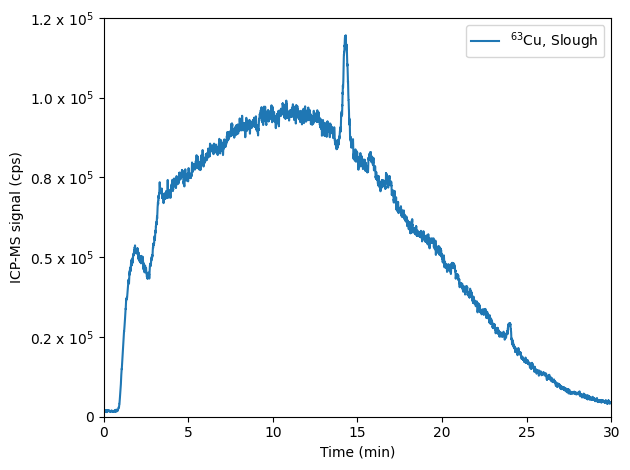

In [8]:
from matplotlib.backends.backend_pdf import PdfPages

flist = ['slough_env.csv']  #'spring_env.csv',
title = 'DOM-Cu'
#flist = ['spring_ppl.csv','slough_ppl.csv']
#title = 'PPL SPE Column'
labels = ['Slough'] #'Seep', 
alphas = [1,0.5]
labs = {f:l for f,l in zip(flist,labels)}
transp = {f:a for f,a in zip(flist,alphas)}

dir = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/'

metals = ['63Cu']
colors = ['C0', 'C1']
cols = {m:c for m,c in zip(metals,colors)}


fig, ax = plt.subplots()

for me in metals:

    maxicp = 0 

    for f in flist:

        icpms_file = dir + f
        icpms = pd.read_csv(icpms_file, sep=';',header=1)
        mw = me[:2]
        sym = me[2:]
        plab = '$^{%s}$%s' %(mw,sym)
        me_key = 'Time %s' %me
        ax.plot(icpms[me_key]/60, icpms[me], label=plab+', '+labs[f],color = cols[me], alpha = transp[f])        
        

#ax.set_ylim(0,maxicp*1.1)
#ax.set_title(title)
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
#ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.legend(bbox_to_anchor=(1.0,1.0),loc='upper right')

ax.set_xlim(0,30)
ax.set_ylim(bottom = 0, top = 1.25e5)
ax.yaxis.set_major_locator(MultipleLocator(2.5e4))

'''x = np.arange(0.0, 4, 0.01)
ax.fill_between(x, 0,1e6,  color = 'gray',alpha=0.5)
x = np.arange(24, 30, 0.01)
ax.fill_between(x, 0,1e6, color = 'gray', alpha=0.5)'''
current_yvalues = plt.gca().get_yticks()
ylabs = []
for y in current_yvalues:
    if y == 0:
        d = int(0)
    else:
        d = '{:.1f} x $10^5$'.format(y/1e5)
    ylabs.append(d)
#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
plt.gca().set_yticklabels(ylabs)


fig.tight_layout()
plt.show()

In [80]:
from tabulate import tabulate
geochem = pd.DataFrame(columns = ['Seep', 'Slough'], index = ['pH', 'Conductivity (mS/cm)','DO (mg/L)','T (C)','Total Cu (uM)', 'Total Fe (uM)', 'DOC (mM)'])

seep = [5.5, 1000,0.1, 8, 100,200,4]
slough = [7.2, 200,8, 8, 50,100,3]

geochem['Seep'] = seep
geochem['Slough'] = slough

geochem

ctest = tabulate(geochem, headers=['Seep', 'Slough'], tablefmt='latex')




/Users/christiandewey/CoreMS


sh: pdflatex: command not found


32512

In [ ]:
alldf = pd.concat([unique_fullmz_456, unique_200mz])
#alldf = unique_100mz_456

times = data_df['Time'].unique()

holder = {}
summary = []
summary2 = []

for mzw in alldf['m/z Window Size'].unique():
    
    sub1 = alldf[alldf['m/z Window Size'] == mzw]

    for t in times:
        
        print(mzw)
        lsh = {}
        lsh['m/z Window Size'] = mzw

        sub2 = sub1[sub1['Time'] == t]

        sub2 = sub2[sub2['S/N'] > 3]
        
        dynamic_range_t = max(sub2['Peak Height']/min(sub2['Peak Height']))
        
        lsh['Time'] = t
        lsh['Dynamic Range'] = dynamic_range_t        
        lsh['n Features'] = len(sub2)
        lsh['Max I'] = max(sub2['Peak Height'])
        lsh['Min I'] = min(sub2['Peak Height'])
        summary.append(lsh)


df=pd.DataFrame(summary)

sns.boxplot(data=df, x="Dynamic Range", y="m/z Window Size")

In [ ]:

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec13.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()